# Changes in Biodiversity Intactness Index influenced by Urban Expansion in The Phoenix Metropolitan Area Over Time

Author: Ixel M. 
GitHub repository: https://github.com/IIDonaji/urban-sprawl-biodiversity-phoenix  

## Purpose: 

what is this notebook about?
## Highlights: 

- Exploring, extracting collections and items from SpatioTemporal Asset Catalog (STAC) 
- Analysing STAC data
- Calculating percent area of the Phoenix subbdivision 
- Maping Results
- Interpreting findings

## About The Data:
- BII `data:io-biodiversity` collection, from the Microsoft Planetary Computer's STAC catalog. This dataset was generated by Impact Observatory, in collaboration with Vizzuality. It contains terrestrial biodiversity intactness data at 100m resolution.

Microsoft Planetary Computer, STAC Catalog. Biodiversity Intactness ('io-biodiversity'). [Dataset]. https://planetarycomputer.microsoft.com/dataset/io-biodiversity Accessed 5 December 2025.

- United States Census Bureau, County Subdivision shapefiles for Arizona. County subdivision level census data from 2022.

United States Census Bureau. (2022). Arizona County Subdivision 2022 TIGER/Line Shapefiles. [Data File]. U.S. Census Bureau, Geography Division. https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions Accessed 5 December 2025.

### References
[1]
Z. Levitt and J. Eng, “Where America’s developed areas are growing: ‘Way off into the horizon’,” The Washington Post, Aug. 2021, Available: https://www.washingtonpost.com/nation/interactive/2021/land-development-urban-growth-maps/. [Accessed: Dec. 4, 2025]
[2]
F. Gassert, J. Mazzarello, and S. Hyde, “Global 100m Projections of Biodiversity Intactness for the years 2017-2020 [Technical Whitepaper].” Aug. 2022. Available: https://ai4edatasetspublicassets.blob.core.windows.net/assets/pdfs/io-biodiversity/Biodiversity_Intactness_whitepaper.pdf

[3]
Microsoft Planetary Computer, STAC Catalog. Biodiversity Intactness ('io-biodiversity'). [Dataset]. https://planetarycomputer.microsoft.com/dataset/io-biodiversity Accessed 5 December 2025.


### Import the following libraries and packages

In [35]:
# Import library using standard abberivations 

import os # for reproducible file paths
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches  # for custom legend


# geospatial tools
import xarray as xr
import rioxarray as rioxr
from shapely.geometry import box

# planetary computer tools
from pystac_client import Client # to access STAC catalog
import planetary_computer # To sign items from the MPC STAC catalog

# for images and mapping
from IPython.display import Image # To nicely display images
import contextily as ctx #for adding basemaps

# Read in Data, Explore and Wrangle

- To access the BII Time Series data we use the `Client` function from the `pystac_client` package
- Narrow down the catalog search by specifying time range, an area of interest, and the collection name.

    - Define area of interest using a `GeoJSON-type` dictionary with the following coordinates for the bouding box:
    
         `[-112.826843, 32.974108, -111.184387, 33.863574]`
    - Search the `io-biodiversity` collection.
    - Use the 2017 and 2020 rasters covering the Phoenix subdivision time range.
- The Phoenix Subdivision Shapefile was downloaded into a data/ folder in the same level as this notebook.

In [2]:
# Access MPC catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace, # `modifier` parameter is needed to access the data in the MPC catalog.
)

# Explore catalog matadata
print('Title:', catalog.title)
print('Description:', catalog.description)

# Pull out the io_biodiversity collection
bio_collection = catalog.get_child('io-biodiversity')

# Reduce outputs exploration with key metadata information
print("\nID:", bio_collection.id)
print("Title:", bio_collection.title)
print("Description:", bio_collection.description)
print("Extent:", bio_collection.extent)

Title: Microsoft Planetary Computer STAC API
Description: Searchable spatiotemporal metadata describing Earth science datasets hosted by the Microsoft Planetary Computer

ID: io-biodiversity
Title: Biodiversity Intactness
Description: Generated by [Impact Observatory](https://www.impactobservatory.com/), in collaboration with [Vizzuality](https://www.vizzuality.com/), these datasets estimate terrestrial Biodiversity Intactness as 100-meter gridded maps for the years 2017-2020.

Maps depicting the intactness of global biodiversity have become a critical tool for spatial planning and management, monitoring the extent of biodiversity across Earth, and identifying critical remaining intact habitat. Yet, these maps are often years out of date by the time they are available to scientists and policy-makers. The datasets in this STAC Collection build on past studies that map Biodiversity Intactness using the [PREDICTS database](https://onlinelibrary.wiley.com/doi/full/10.1002/ece3.2579) of spa

In [3]:
# Temporal range of interest (BII rasters 4-year window)
time_range = "2017-01-01/2020-01-01"

# Define bbox around Phoenix subdivision
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

# Search items in the collection
search = catalog.search(
    collections = ['io-biodiversity'],
    bbox = bbox,
    datetime = time_range)

# Retrieve search items 
items = search.item_collection()
print(f"There is {len(items)} items in the search.") # Output identifies 4 items (BII rasters found for Phoenix from 2017–2020) in catalog that match search

There is 4 items in the search.


In [4]:
# Get items as a list
all_items = list(search.items())

# Print item ID and properties
for item in all_items:
    print(item.id, item.properties)

bii_2020_34.74464974521749_-115.38597824385106_cog {'datetime': None, 'proj:epsg': 4326, 'proj:shape': [7992, 7992], 'end_datetime': '2020-12-31T23:59:59Z', 'proj:transform': [0.0008983152841195215, 0.0, -115.38597824385106, 0.0, -0.0008983152841195215, 34.74464974521749, 0.0, 0.0, 1.0], 'start_datetime': '2020-01-01T00:00:00Z'}
bii_2019_34.74464974521749_-115.38597824385106_cog {'datetime': None, 'proj:epsg': 4326, 'proj:shape': [7992, 7992], 'end_datetime': '2019-12-31T23:59:59Z', 'proj:transform': [0.0008983152841195215, 0.0, -115.38597824385106, 0.0, -0.0008983152841195215, 34.74464974521749, 0.0, 0.0, 1.0], 'start_datetime': '2019-01-01T00:00:00Z'}
bii_2018_34.74464974521749_-115.38597824385106_cog {'datetime': None, 'proj:epsg': 4326, 'proj:shape': [7992, 7992], 'end_datetime': '2018-12-31T23:59:59Z', 'proj:transform': [0.0008983152841195215, 0.0, -115.38597824385106, 0.0, -0.0008983152841195215, 34.74464974521749, 0.0, 0.0, 1.0], 'start_datetime': '2018-01-01T00:00:00Z'}
bii_201

The exploration shows item ID's and properties for the io_biodiversity collection. Notice 'datetime' NONE in these items makes sense because there is no single moment in time. Year is available inside start_datetime and end_datetime because  annual composites. 

In [5]:
# Get items in the catalog want 2020 and 2017 rasters
# Create a lookup table
lookup = {int(item.properties["start_datetime"][:4]): item for item in items} # year is available inside start_datetime not datetime 

# Store year propeties for later analysis
raster_2017 = lookup[2017]
raster_2020 = lookup[2020]

# Explore year raster keys
def show_assets(item):
    print(f"\nAssets for item: {item.id}")
    print("--" *40)
    for key, asset in item.assets.items():
        print(f"{key:12} -> {asset.title}")
        
show_assets(raster_2017)
show_assets(raster_2020)
    


Assets for item: bii_2017_34.74464974521749_-115.38597824385106_cog
--------------------------------------------------------------------------------
data         -> Biodiversity Intactness
tilejson     -> TileJSON with default rendering
rendered_preview -> Rendered preview

Assets for item: bii_2020_34.74464974521749_-115.38597824385106_cog
--------------------------------------------------------------------------------
data         -> Biodiversity Intactness
tilejson     -> TileJSON with default rendering
rendered_preview -> Rendered preview


This asset exploration helps confirm correct raster and ensure we open the correct asset for later analysis. Each asset also contains an href, which will help retireve the data for later analysis. 

In [6]:
# Import Arizona Census Subdivision data

# display all columns when looking at dataframes
pd.set_option("display.max.columns", None)

arizona_fp = os.path.join('data','tl_2022_04_cousub','tl_2022_04_cousub.shp')
arizona = gpd.read_file(arizona_fp)

# preliminary exploration
arizona.head(2)

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,005,91198,01934931,0400591198,Flagstaff,Flagstaff CCD,22,Z5,G4040,None,None,None,S,12231052883,44653332,+35.1066114,-111.3662497,"POLYGON ((-112.13370 35.85596, -112.13368 35.8..."
1,04,005,91838,01934953,0400591838,Kaibab Plateau,Kaibab Plateau CCD,22,Z5,G4040,None,None,None,S,7228864534,29327221,+36.5991097,-112.1368033,"POLYGON ((-112.66039 36.53941, -112.66033 36.5..."


Clean column names, select Phoenix County, and check CRS.
Its important to check CRS when working with geospatial data in order to perform analysis.  

In [7]:
# Change column names to lower case
arizona.columns = arizona.columns.str.lower()

# Filter for Phoenix
phoenix = arizona[arizona.name == "Phoenix"]

print(phoenix.crs)

EPSG:4269


Phoenix CRS differ from raster_2017 and raster_2020. This would need to be changed for analysis.

# Geographic Context 
Map the Phoenix subdivision within its broader geographic context. 
- Use a basemap from the [Contextily](https://contextily.readthedocs.io/en/latest/) package. The basemap function `add_basemap` can be modified by updating the `source` paramater. By defualt the [OpenStreeMapHOT](https://contextily.readthedocs.io/en/latest/intro_guide.html) style is used.

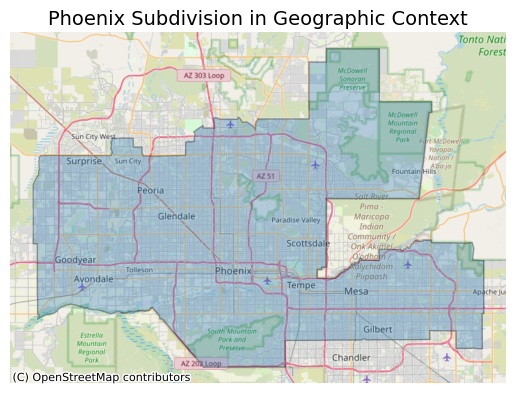

In [8]:
# Set up figure
fig, ax = plt.subplots()

# Create axis with plot
(phoenix.to_crs(epsg=3857) 
      .plot(ax=ax, figsize=(11, 10), alpha=0.30, edgecolor="black"))

# Add NatGeo basemap from contextily
ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Update axes
ax.set_title("Phoenix Subdivision in Geographic Context", fontdict= {"fontsize": "14"})
ax.set_axis_off()

# Saving map as an image for later use
plt.savefig('figures/phoenix_county.png', bbox_inches = "tight", dpi = 100)

# Plot Biodiversity Intactness in the Phoenix subdivision
- Need to calculate percentage of the Phoenix subdivision area with a BII of at least 0.75 in 2017 and do the same for 2020.
    - Recall raster_2017 and raster_2020 it's data is in the 'data' asset, open them directly using `rioxr.open_rasterio()`.
    - Check raster (xarray) CRS match shapefile. 
    - Clip BII datas and Phoenix data to geometry of the Phoenix subdivision polygon.
    - Calculate percentage area
    - Check precent calculations over Phoenix area are not the complete rasters extents.
- Final visualization should show the area with BII >= 0.75 that was lost by 2020.

In [9]:
# Open raster data for year 2017 and 2020 use squeeze() to simplify
bii_2017 = rioxr.open_rasterio(raster_2017.assets['data'].href).squeeze()
bii_2020 = rioxr.open_rasterio(raster_2020.assets['data'].href).squeeze()

# Perform CRS's check with conditional statement
print(f" The Phoenix shapefile CRS is currently: {phoenix.crs.to_epsg()}")

if (phoenix.crs != bii_2017.rio.crs):
    phoenix = phoenix.to_crs(bii_2017.rio.crs)
    
print(f" The 2017 BII raster CRS is currently: {bii_2017.rio.crs.to_epsg()}")

print(f" The Phoenix shapefile CRS is now: {phoenix.crs.to_epsg()}")

 The Phoenix shapefile CRS is currently: 4269
 The 2017 BII raster CRS is currently: 4326
 The Phoenix shapefile CRS is now: 4326


In [18]:
# Reduce raster before polygon_masking
b2017_box = bii_2017.rio.clip_box(*phoenix.total_bounds)
b2020_box = bii_2020.rio.clip_box(*phoenix.total_bounds)

# Clip small region to polygon
phoenix_geom = list(phoenix.geometry)

# Clipping 2017 BII raster to the Phoenix polygon
phoenix_clip_2017 = b2017_box.rio.clip(phoenix_geom, crs=phoenix.crs, drop=True)

# Performing this same step for the 2020 data:
phoenix_clip_2020 = b2020_box.rio.clip(phoenix_geom, crs=phoenix.crs, drop=True)

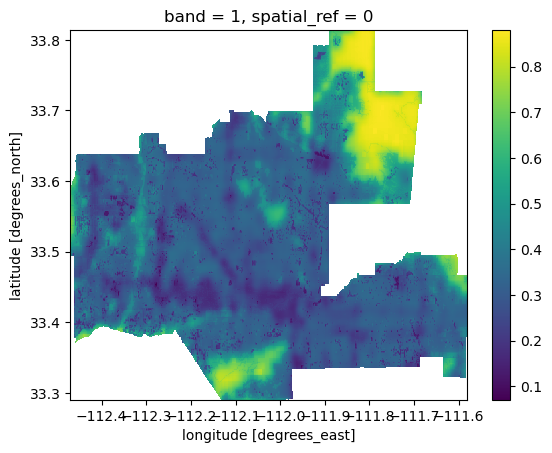

In [19]:
# View output of BII 
fig, ax = plt.subplots()
phoenix_clip_2017.plot(ax=ax)

In [20]:
# Create a masks to finds the values where for BII >= 0.75 
mask_2017 = (phoenix_clip_2017 >= 0.75).astype(int)
mask_2020 = (phoenix_clip_2020 >= 0.75).astype(int)

# Find the count for area in year in 2017 and 2020
count_2017 = phoenix_clip_2017.count().item()
count_2020 = phoenix_clip_2020.count().item()

pixels_2017 = mask_2017.sum().item()
pixels_2020 = mask_2020.sum().item()

# Calculate percentage of area with BII >= 0.75
percent_2017 = (pixels_2017 / count_2017) * 100
percent_2020 = (pixels_2020 / count_2020) * 100

# viewing percentages:
pct_text = "The percentage of area in Phoenix County with a BII over 0.75 in"
print(f"{pct_text}, 2017 is: {percent_2017:.2}%")
print(f"\n{pct_text}, 2020 is: {percent_2020:.2}%")
change = percent_2020 - percent_2017
print(f"\nChange from 2017 to 2020: {change:.2f}%")

The percentage of area in Phoenix County with a BII over 0.75 in, 2017 is: 7.1%

The percentage of area in Phoenix County with a BII over 0.75 in, 2020 is: 6.5%

Change from 2017 to 2020: -0.63%


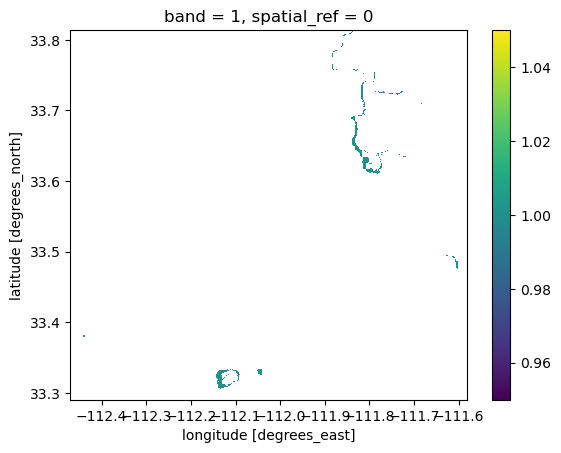

<Figure size 400x500 with 0 Axes>

In [40]:
# Create a difference mask to identify where status changed between two years
diff_mask = mask_2017 ^ mask_2020

# Include only changed pixels and set others to NaN
loss_numeric = diff_mask.where(diff_mask, other = np.nan)

# Plot loss areas to visualize where BII changed
loss_numeric.plot()
plt.figure(figsize=(4,5))
plt.show()


In [51]:
#  Calculate the BII loss
bii_loss = mask_2017 == 1 & (~mask_2020 == 0)

# Initialize plot
fig, ax = plt.subplots(figsize=(8, 7))

# Remove axes for a cleaner plot
ax.axis("off")

# Plot 2020 BII 
phoenix_clip_2020.plot(ax=ax, 
                       cmap='Greens',
                       vmin=0, vmax=1, 
                       cbar_kwargs={'label': 'BII for (2020)', 
                                  'shrink': 0.5, 
                                  'orientation': 'horizontal',
                                  'pad': 0.15})

# Plot numerized area loss (NaN not included)
loss_numeric.plot(
                 ax=ax, # share axes
                  cmap = "Reds, # our predefined colormap object
                  add_colorbar = False # we're going to make a custom legend, so we don't want the default one
)

# Define legend for patch
loss_patch = mpatches.Patch(color = "red",
                                   label = "Area where BII ≥ 75% from 2017 to 2020")



# Phoenix polygon outline layer
phoenix.plot(ax = ax, # share axes (on the same plot as everything else)
             color = "none", # transparent fill, we just want the outline
             edgecolor = "black",
             linewidth = 2
            )


# Legend
# update legend, add in BII loss patch
ax.legend(handles = [loss_patch],
          frameon = False,
          bbox_to_anchor = (0.85, -0.07))

# Titles
ax.set_title("Biodiversity Intactness Index (BII) - Phoenix subdivision")


plt.show()

SyntaxError: unterminated string literal (detected at line 22) (235497761.py, line 22)